In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools
import torch
import csv
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output

In [2]:
import sys
import os
import gc

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from Model.Featureless import MainNetwork

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
    print(f"Use GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu") 
    print("Use CPU")

def load_or_calc_save_freq_data(file_path, X, Y):
  if os.path.exists(file_path):
    data = torch.tensor(pd.read_csv(file_path).values, dtype=torch.float)
  else:
    data = calc_freq(X, Y)
    pd.DataFrame(data.cpu().numpy()).to_csv(file_path, index=False)  # 保存到文件
  return data

Use GPU: NVIDIA GeForce RTX 4060


In [4]:
def calc_freq(X, Y): 
    # looks at unique item sets of X -> for each: avg the Y choices made by users 
    # This is used for evaluation to give a smoother estimate (not used for training)
    X = X.float()
    Y = Y.float()
    unique_X, inverse_indices = torch.unique(X, dim=0, return_inverse=True)
    new_Y = torch.zeros_like(Y)
    for k in range(unique_X.shape[0]):
        mask = (inverse_indices == k)
        avg_y = torch.mean(Y[mask], dim=0)
        new_Y[mask] = avg_y
    return new_Y

In [5]:
def eval_rmse(model, X, Y, batch_size, loss_fn):
    model.eval()
    n = X.size(0)
    total_loss = 0.0
    total_n = 0
    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            xb = X[start:end].to(device)
            yb = Y[start:end].to(device)
            out, _ = model(xb)
            loss = loss_fn(out, yb)
            total_loss += loss.item() * (end - start)
            total_n += (end - start)
    return (total_loss / total_n) ** 0.5

In [6]:
def train_deephalo_synthetic(loss_name, num_epochs, depth, reswidth, batch_size, input_dim, lr, patience):
    main_network = MainNetwork(input_dim, depth, reswidth, ['qua']*(depth-1))
    main_network.to(device)

    start_epoch = 0
    loss_record = {'insample_rmse_list': [], 'insample_rmse_freq_list': [], 'outsample_rmse_list': [], 'outsample_rmse_freq_list': [], 'insample_step_rmse_list': []}
    train_file_path = os.path.join(project_root, 'Data', 'Synthetic_20-15-80_Train.csv')
    test_file_path = os.path.join(project_root, 'Data', 'Synthetic_20-15-20_Test.csv')

    df_train = pd.read_csv(train_file_path)
    df_test = pd.read_csv(test_file_path)

    X_columns = [col for col in df_train.columns if col.startswith('X')]
    Y_columns = [col for col in df_train.columns if col.startswith('Y')]

    X_train = torch.tensor(df_train[X_columns].values, dtype=torch.float)
    Y_train = torch.tensor(df_train[Y_columns].values, dtype=torch.float)

    X_test = torch.tensor(df_test[X_columns].values, dtype=torch.float)
    Y_test = torch.tensor(df_test[Y_columns].values, dtype=torch.float)

    train_freq_file_path = os.path.join(project_root, 'Data', 'Synthetic_20-15-80_Train_Freq.csv')
    test_freq_file_path = os.path.join(project_root, 'Data', 'Synthetic_20-15-20_Test_Freq.csv')

    Y_train_freq = load_or_calc_save_freq_data(train_freq_file_path, X_train, Y_train)
    Y_test_freq = load_or_calc_save_freq_data(test_freq_file_path, X_test, Y_test)

    '''
    X_train_eval = X_train.to(device)
    Y_train_eval = Y_train.to(device)
    Y_train_freq_eval = Y_train_freq.to(device)

    X_test_eval = X_test.to(device)
    Y_test_eval = Y_test.to(device)
    Y_test_freq_eval = Y_test_freq.to(device)
    '''

    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # creates an iterator that generates mini-batches
    optimizer = Adam(main_network.parameters(), lr=lr)

    in_sample_loss = None
    in_sample_freq_loss = None
    out_sample_loss = None
    out_sample_freq_loss = None

    in_sample_freq_loss_list = []
    out_sample_freq_loss_list = []

    in_sample_loss_list = []
    out_sample_loss_list = []

    step_loss_list = []

    if loss_name == 'NLL':
        L = log_likelihood
    else:
        L = nn.MSELoss()

    best_loss = float('inf')
    logs = f"Resuming training for model with Depth {depth} and Width {reswidth} from epoch {start_epoch}." + '\n'
    
    epochs_without_improvement = 0 # added

    for epoch in range(start_epoch, num_epochs):
        main_network.train()  # added
        
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            data, target = data.to(device), target.to(device)
            output, _ = main_network(data)
            loss = L(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                step_loss_list.append(loss.item() ** 0.5)

        '''
        with torch.no_grad():
            in_sample_output, _ = main_network(X_train_eval)
            out_sample_output, _ = main_network(X_test_eval)

            in_sample_freq_loss = L(in_sample_output, Y_train_freq_eval).item() ** 0.5
            in_sample_loss = L(in_sample_output, Y_train_eval).item() ** 0.5

            out_sample_freq_loss = L(out_sample_output, Y_test_freq_eval).item() ** 0.5
            out_sample_loss = L(out_sample_output, Y_test_eval).item() ** 0.5

            in_sample_freq_loss_list.append(in_sample_freq_loss)
            in_sample_loss_list.append(in_sample_loss)
            out_sample_freq_loss_list.append(out_sample_freq_loss)
            out_sample_loss_list.append(out_sample_loss)
        '''

        # batched evaluation to avoid GPU OOM
        in_sample_loss = eval_rmse(main_network, X_train, Y_train, batch_size=4096, loss_fn=L)
        in_sample_freq_loss = eval_rmse(main_network, X_train, Y_train_freq, batch_size=4096, loss_fn=L)
        out_sample_loss = eval_rmse(main_network, X_test, Y_test, batch_size=4096, loss_fn=L)
        out_sample_freq_loss = eval_rmse(main_network, X_test, Y_test_freq, batch_size=4096, loss_fn=L)

        in_sample_freq_loss_list.append(in_sample_freq_loss)
        in_sample_loss_list.append(in_sample_loss)
        out_sample_freq_loss_list.append(out_sample_freq_loss)
        out_sample_loss_list.append(out_sample_loss)


        if (epoch + 1) % 5 == 0:
            logs += f'Epoch [{epoch + 1}/{num_epochs}], Original Loss: {in_sample_loss:.4f},' \
                    f' Frequency Loss: {in_sample_freq_loss:.8f}\n'
        clear_output(wait=True)

        print(logs)
        plt.plot(in_sample_loss_list, label='In-Sample Loss')
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

        # epochs_without_improvement not initialised to 0 before checking
        
        # they evaluate RMSE smoothed by frequency -> this would be a better measure from patience evaluation
        if patience:
            if in_sample_loss < best_loss - 1e-5:
                best_loss = in_sample_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
    
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    model_info = {
        'model_para': main_network.state_dict(),
    
        'model_hyperpara': {'depth': depth,
                            'resnet_width': reswidth,
                            'epoch': num_epochs,
                            'batch_size': batch_size,
                            'lr': lr,
                            'loss_name': loss_name},
    
        'result': {'insample_rmse': in_sample_loss,
                   'insample_rmse_freq': in_sample_freq_loss,
                   'outsample_rmse': out_sample_loss,
                   'outsample_rmse_freq': out_sample_freq_loss},
    
        'loss_record': {'insample_rmse_list': in_sample_loss_list,
                        'insample_rmse_freq_list': in_sample_freq_loss_list,
                        'outsample_rmse_list': out_sample_loss_list,
                        'outsample_rmse_freq_list': out_sample_freq_loss_list,
                        'insample_step_rmse_list': step_loss_list},
    }

    file_path = os.path.join(project_root, 'Model', 'Synthetic')
    torch.save(model_info, file_path + 'Depth-' + str(depth) + '-Width-'+ str(reswidth) + 'Model-syn-20-15-80-20.pth')

    print(model_info['model_hyperpara'])
    print(model_info['result'])

    del main_network, optimizer
    gc.collect()
    torch.cuda.empty_cache()




In [7]:
def param_count(depth, width):
    return (depth - 1) * (width**2 + width) + 42 * width

In [8]:
# calculates the width required to keep the num of para close to 500000

def count_params(depth, width):
    return (depth - 1) * (width ** 2 + width) + 42 * width #this fomula is diff from paper and possibly wrong??

budget = 500000
tolerance = 0.003  # ±2%
min_params = int(budget * (1 - tolerance))
max_params = int(budget * (1 + tolerance))

candidates = []
for depth in range(3, 8):  # must have at least input/output layers
    for width in range(100, 1000):
        p = count_params(depth, width)
        if min_params <= p <= max_params:
            candidates.append((depth, width, p))

# Sort by width or depth if needed
candidates.sort(key=lambda x: x[0])  # sort by depth

for d, w, p in candidates[:10]:
    print('depth', d, 'width', w, 'params', p)


depth 3 width 489 params 499758
depth 4 width 401 params 500448
depth 5 width 348 params 500424
depth 6 width 312 params 501384
depth 7 width 285 params 501030


Resuming training for model with Depth 5 and Width 348 from epoch 0.
Epoch [5/5], Original Loss: 0.2153, Frequency Loss: 0.05589811



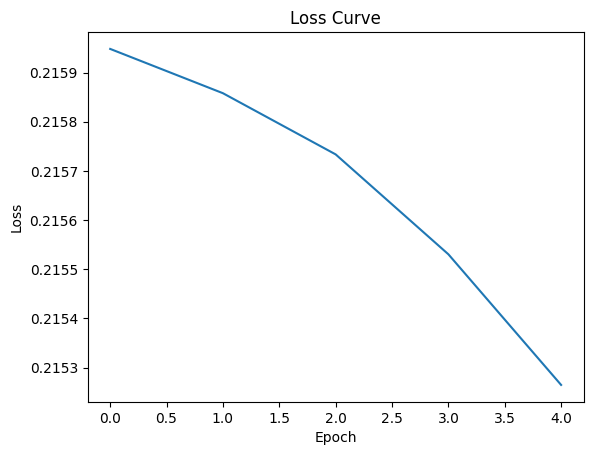

{'depth': 5, 'resnet_width': 348, 'epoch': 5, 'batch_size': 1024, 'lr': 0.0001, 'loss_name': 'MSE'}
{'insample_rmse': 0.21526478250539774, 'insample_rmse_freq': 0.05589810553416006, 'outsample_rmse': 0.2154892028442765, 'outsample_rmse_freq': 0.0696957891327801}


"\nfor budget, configs in experiments.items():\n    print(f'=== Testing Budget Group: {budget} ===')\n    for depth, width in configs:\n        num_params = param_count(depth, width)\n        print(f'Depth: {depth}, Width: {width} → Parameter Num: {num_params}')\n        train_deephalo_synthetic(Loss_Name, epochs, depth, width, batch_size, dim, learning_rate, patience)\n    "

In [7]:
Loss_Name = 'MSE'
epochs = 5
dim = 20
batch_size = 1024
num_workers = 0 #what is this?
learning_rate = 0.0001
patience = None
experiments = {
    # '10k': [(3, 60), (4, 51), (5, 45), (6, 40), (7, 37)],
    # '30k': [(4, 60), (5, 52), (6, 48), (7, 44)],
    # '200k': [(3, 306), (4, 251), (5, 218), (6, 195), (7, 179)],
    '500k': [(7, 285), (6, 312), (5, 348), (4, 401), (3, 489)],
}

depth = 5
width = 348
train_deephalo_synthetic(Loss_Name, epochs, depth, width, batch_size, dim, learning_rate, patience)


'''
for budget, configs in experiments.items():
    print(f'=== Testing Budget Group: {budget} ===')
    for depth, width in configs:
        num_params = param_count(depth, width)
        print(f'Depth: {depth}, Width: {width} → Parameter Num: {num_params}')
        train_deephalo_synthetic(Loss_Name, epochs, depth, width, batch_size, dim, learning_rate, patience)
    '''